In [1]:
!pip install -e ..

Obtaining file:///export/home/figs/vdesouza/work/Holography-1022/astrohack
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for astrohack (pyproject.toml) ... done
  Created wheel for astrohack: filename=astrohack-0.0.1-py3-none-any.whl size=1061 sha256=59f59d1e6272b2f472c5ed799d07c7c8fb2fa0681314ade2716b2f218436951c
  Stored in directory: /tmp/pip-ephem-wheel-cache-n8toco6l/wheels/93/bb/ed/46bdf801cce81c3aea69f1f4af83e386e0f89149047ab78ae0
Successfully built astrohack
  Attempting uninstall: astrohack
    Found existing installation: astrohack 0.0.1
    Uninstalling astrohack-0.0.1:
      Successfully uninstalled astrohack-0.0.1


In [2]:
import os
import tarfile
import shutil
import dask
import requests
import time
import psutil

import numpy as np
import xarray as xr
import scipy.constants
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astrohack import holog
from astrohack.panel import panel

from astrohack.extract_holog import extract_holog

from astrohack._utils._holog import _make_ant_pnt_dict

from astrohack._utils._io import _load_holog_file
from astrohack._utils._io import _load_image_file
from astrohack._utils._io import _read_meta_data

from astrohack.dio import AstrohackDataFile
from astrohack.visualization.viewer import ApertureViewer

from dask.distributed import Client, LocalCluster

plt.rcParams["figure.figsize"] = (25, 25)

In [3]:
def performance(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        stop = time.time()
        print("Completion time: {}".format(stop - start))
    return wrapper

def _open_holog(hack_file, ddi):   
    ant_grid_data = {}
    
    ant_list =  [dir_name for dir_name in os.listdir(hack_file) if os.path.isdir(hack_file)]
    for ant in ant_list:
        ant_grid_data[int(ant)] = xr.open_zarr("{name}/{ant}/{ddi}".format(name=hack_file, ant=ant, ddi=ddi) )
        
    return ant_grid_data

def print_hack_file(hack):
    for ddi in hack.keys():
        for scan in hack[ddi].keys():
            for ant in hack[ddi][scan].keys():
                print("="*150)
                print("\t\t\t\t\t\t\tddi={ddi}\tscan={scan}\t ant={ant}".format(ddi=ddi, scan =scan, ant=ant))
                print("="*150)
                print("{xds}".format(xds=hack[ddi][scan][ant]))

def print_hack_directory_struct(name):
    for ddi in os.listdir(name):
        if ddi.isnumeric():
            print(ddi,"/")
            for scan in os.listdir("{name}/{ddi}".format(name=name, ddi=ddi)):
                if os.path.isdir("{name}/{ddi}/{scan}/".format(name=name, ddi=ddi, scan=scan)) == False:
                    print("|---", scan)
                    pass
                else:
                    print("|---", scan, "/")
                    for ant in os.listdir("{name}/{ddi}/{scan}/".format(name=name, ddi=ddi, scan=scan)):
                        print("\t|---", ant, "/")
                
def get_max_memory_allocation():
    memory_string = str(int((psutil.virtual_memory().total/1e9)/os.cpu_count()))
    return "".join((memory_string, 'GB'))

def get_example_data():
    #google_file_id = '1zpOtduyXtbh0wg0s5KWYuEMy7roGq92a'
    google_file_id = '10lX6kki638xeDhDKw51tk0h9pbleMx0z'
    #output = 'alma_band3.calibrated.DV16.ms.tar'
    output = 'alma_band3.calibrated.DA44.ms.tar'
    path = "/".join((os.getcwd(), output))
    
    download_file_from_google_drive(
        id=google_file_id,
        destination=path
    )

    
    tar = tarfile.open(path)
    tar.extractall()
    tar.close()
    
    os.remove(path)
    
    return path.split('.tar')[0]

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id , 'confirm': 1 }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Setup
This data file is a subset of a larger band3, calibrated holography measurement. The file contains a single ddi, a single scan and only baselines containing antenna DV16.

In [4]:
if os.path.exists('alma_band3.calibrated.DA44.ms') == False:
    ms_name = get_example_data()
    pass
else:
    ms_name = 'alma_band3.calibrated.DA44.ms'
    
# Change this to the path to the larger file
#ms_name = '<PATH_TO_LARGER_FILE>/J1924-2914.ms.split.calibrated.SPW3'

Here we setup the Dask distributed client which will be used to add parallelism to our jobs. In this case, we will use a total of 6 workers with a single thread and 8Gb of memeory each. The dashboard link that is returned allows the user to monitor each jobs from the browser.

![title](documentation/dask_dashboard.png)

In [5]:
try:
    client = Client('http://127.0.0.1:8787')

except:
    cluster = LocalCluster(
        n_workers=6,
        threads_per_worker=1,
        memory_limit='8GB'
    )

    client = Client(cluster)
        
print(client.dashboard_link)

2023-03-27 17:13:09,627 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-u928w0n4', purging
2023-03-27 17:13:09,628 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-jryqk5bc', purging
2023-03-27 17:13:09,628 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-rig57e1l', purging


http://127.0.0.1:8787/status


This input format to the `extract_holog(...)` function is in the form of a nested dictionary. The structure is as follows:
```yaml
ddi: {
    scan:{
         'map':[mapping antenna list]
         'ref':[reference antenna list]
         }
    }
},
.
.
.
ddi_n: {
    scan_n:{
         'map':[mapping antenna list]
         'ref':[reference antenna list]
         }
    }
}
```
The above is the structure for the case of a single (ddi, scan_ but the format can support *n* cases of (ddi, scan). This is user provided information based on the specific holography run being processed.

In [6]:
holog_obs_description = {
    0 :{
        'scans':[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
        'ant':{
            'DA44':[
                'DV02', 'DV03', 'DV04', 
                'DV11', 'DV12', 'DV13', 
                'DV14', 'DV15', 'DV16', 
                'DV17', 'DV18', 'DV19', 
                'DV20', 'DV21', 'DV22', 
                'DV23', 'DV24', 'DV25'
            ]
        }
    }
}

holog_obs_description['ddi'] = np.arange(1)

print(aperture_radius) # Extract Holography Data

The extraction of the holography data is done effectively by leveraging the Dask based parallelism and compiled code via numba jit functions. There are also optimizations done by extracting only the minimum subsets of data that are needed to build the output data structure which will be used for the holography analysis. In addition, we found significant table query gains by using `pycasacore`; as much as x10 speed up. A psuedocode skeleton of how the extraction is done is shown below.

- `extract_holog(...)`
    - `make_pnt_dict`(parallel axis: `antenna`) extract a subset of the pointing table data needed for the holography analysis. 
    - gather relevant spectral window information as well as odservation type information,  e.g.(MAP_ANTENNA_SURFACE#MIXED). Only keep data of a relevant type.
    - `_extract_holog_chunk(...)`(parallel axes: ddi, scan) 
        - pull data from main table
        - get unique scan time values
        - `_extract_holog_chunk_jit` (this is jit compiled code): 
            - for each row:
                - skip flagged rows
                - get only relevant baselines, i.e. no auto correlation
                - get baseline visibility data
                - for each chan, pol:
                    - calculate weighted sum visibilities 
                    - calculate running sum of weights
            - for unique_time, chan, pol:
                - calculate weighted visibilities
    - `_extract_pointing_chunk(...)`
        - extract directional cosines data by sampling the time values nearest the main table unique values.
    - `_create_hack_file(...)`
        - create hackfile data structure that contains both the visibility and the directional cosines data using common time indexing.
                


In [7]:
%%time
extract_holog(
    ms_name=ms_name, 
    holog_name='hack_file', 
    holog_obs_dict=holog_obs_description,
    data_col='DATA',
    subscan_intent='MIXED',
    parallel=True,
    overwrite=True
)

[2023-03-27 17:13:10.290950 Warning]: [extract_holog] Warning, current holography files will be overwritten.
[2023-03-27 17:13:10.485705 System Info]: Opening measurement file alma_band3.calibrated.DA44.ms/DATA_DESCRIPTION
[2023-03-27 17:13:10.489064 System Info]: [extract_holog]: Processing DDI: [0]
[2023-03-27 17:13:10.489092 System Info]: [extract_holog]: Processing select DDI: 0
[2023-03-27 17:13:10.489319 System Info]: Processing ddi: 0, scans: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
CPU times: user 696 ms, sys: 64.7 ms, total: 761 ms
Wall time: 8.18 s


The output of `extract_holog(...)` is `hackfile` containing the extract holography information for each (ddi, scan, ant) as well as relevant meta data used later for gridding. The format of the `hackfile` on disk is a directory structure ordered as `hackfile/ddi/scan/antenna/` with an `xarray.Dataset()` at the end.

The directory structure and `xarray.Dataset()` format are shown below for the example data.

In [8]:
astrohack_data_file = AstrohackDataFile(file_stem='hack_file')

astrohack_data_file.holog.open()

antenna = 'ant_3'
ddi = 'ddi_0'
scan = 'scan_0'

[2023-03-27 17:13:18.472481 System Info]: Verifying hack_file.* files in path=./ ...
[2023-03-27 17:13:18.475328 System Info]: Found hack_file.holog.zarr directory ...


In addition to producing the `hackfile` and antenna based dictionary is also produced which is indexed according to antenna/ddi/scan. This allows us to more easily access the data for antenna based gridding in Dask. An example for antenna-27 is shown below.

In [9]:
time = astrohack_data_file.holog[ddi][scan][antenna].time.values
l = astrohack_data_file.holog[ddi][scan][antenna].DIRECTIONAL_COSINES[:, 0]
m = astrohack_data_file.holog[ddi][scan][antenna].DIRECTIONAL_COSINES[:, 1]

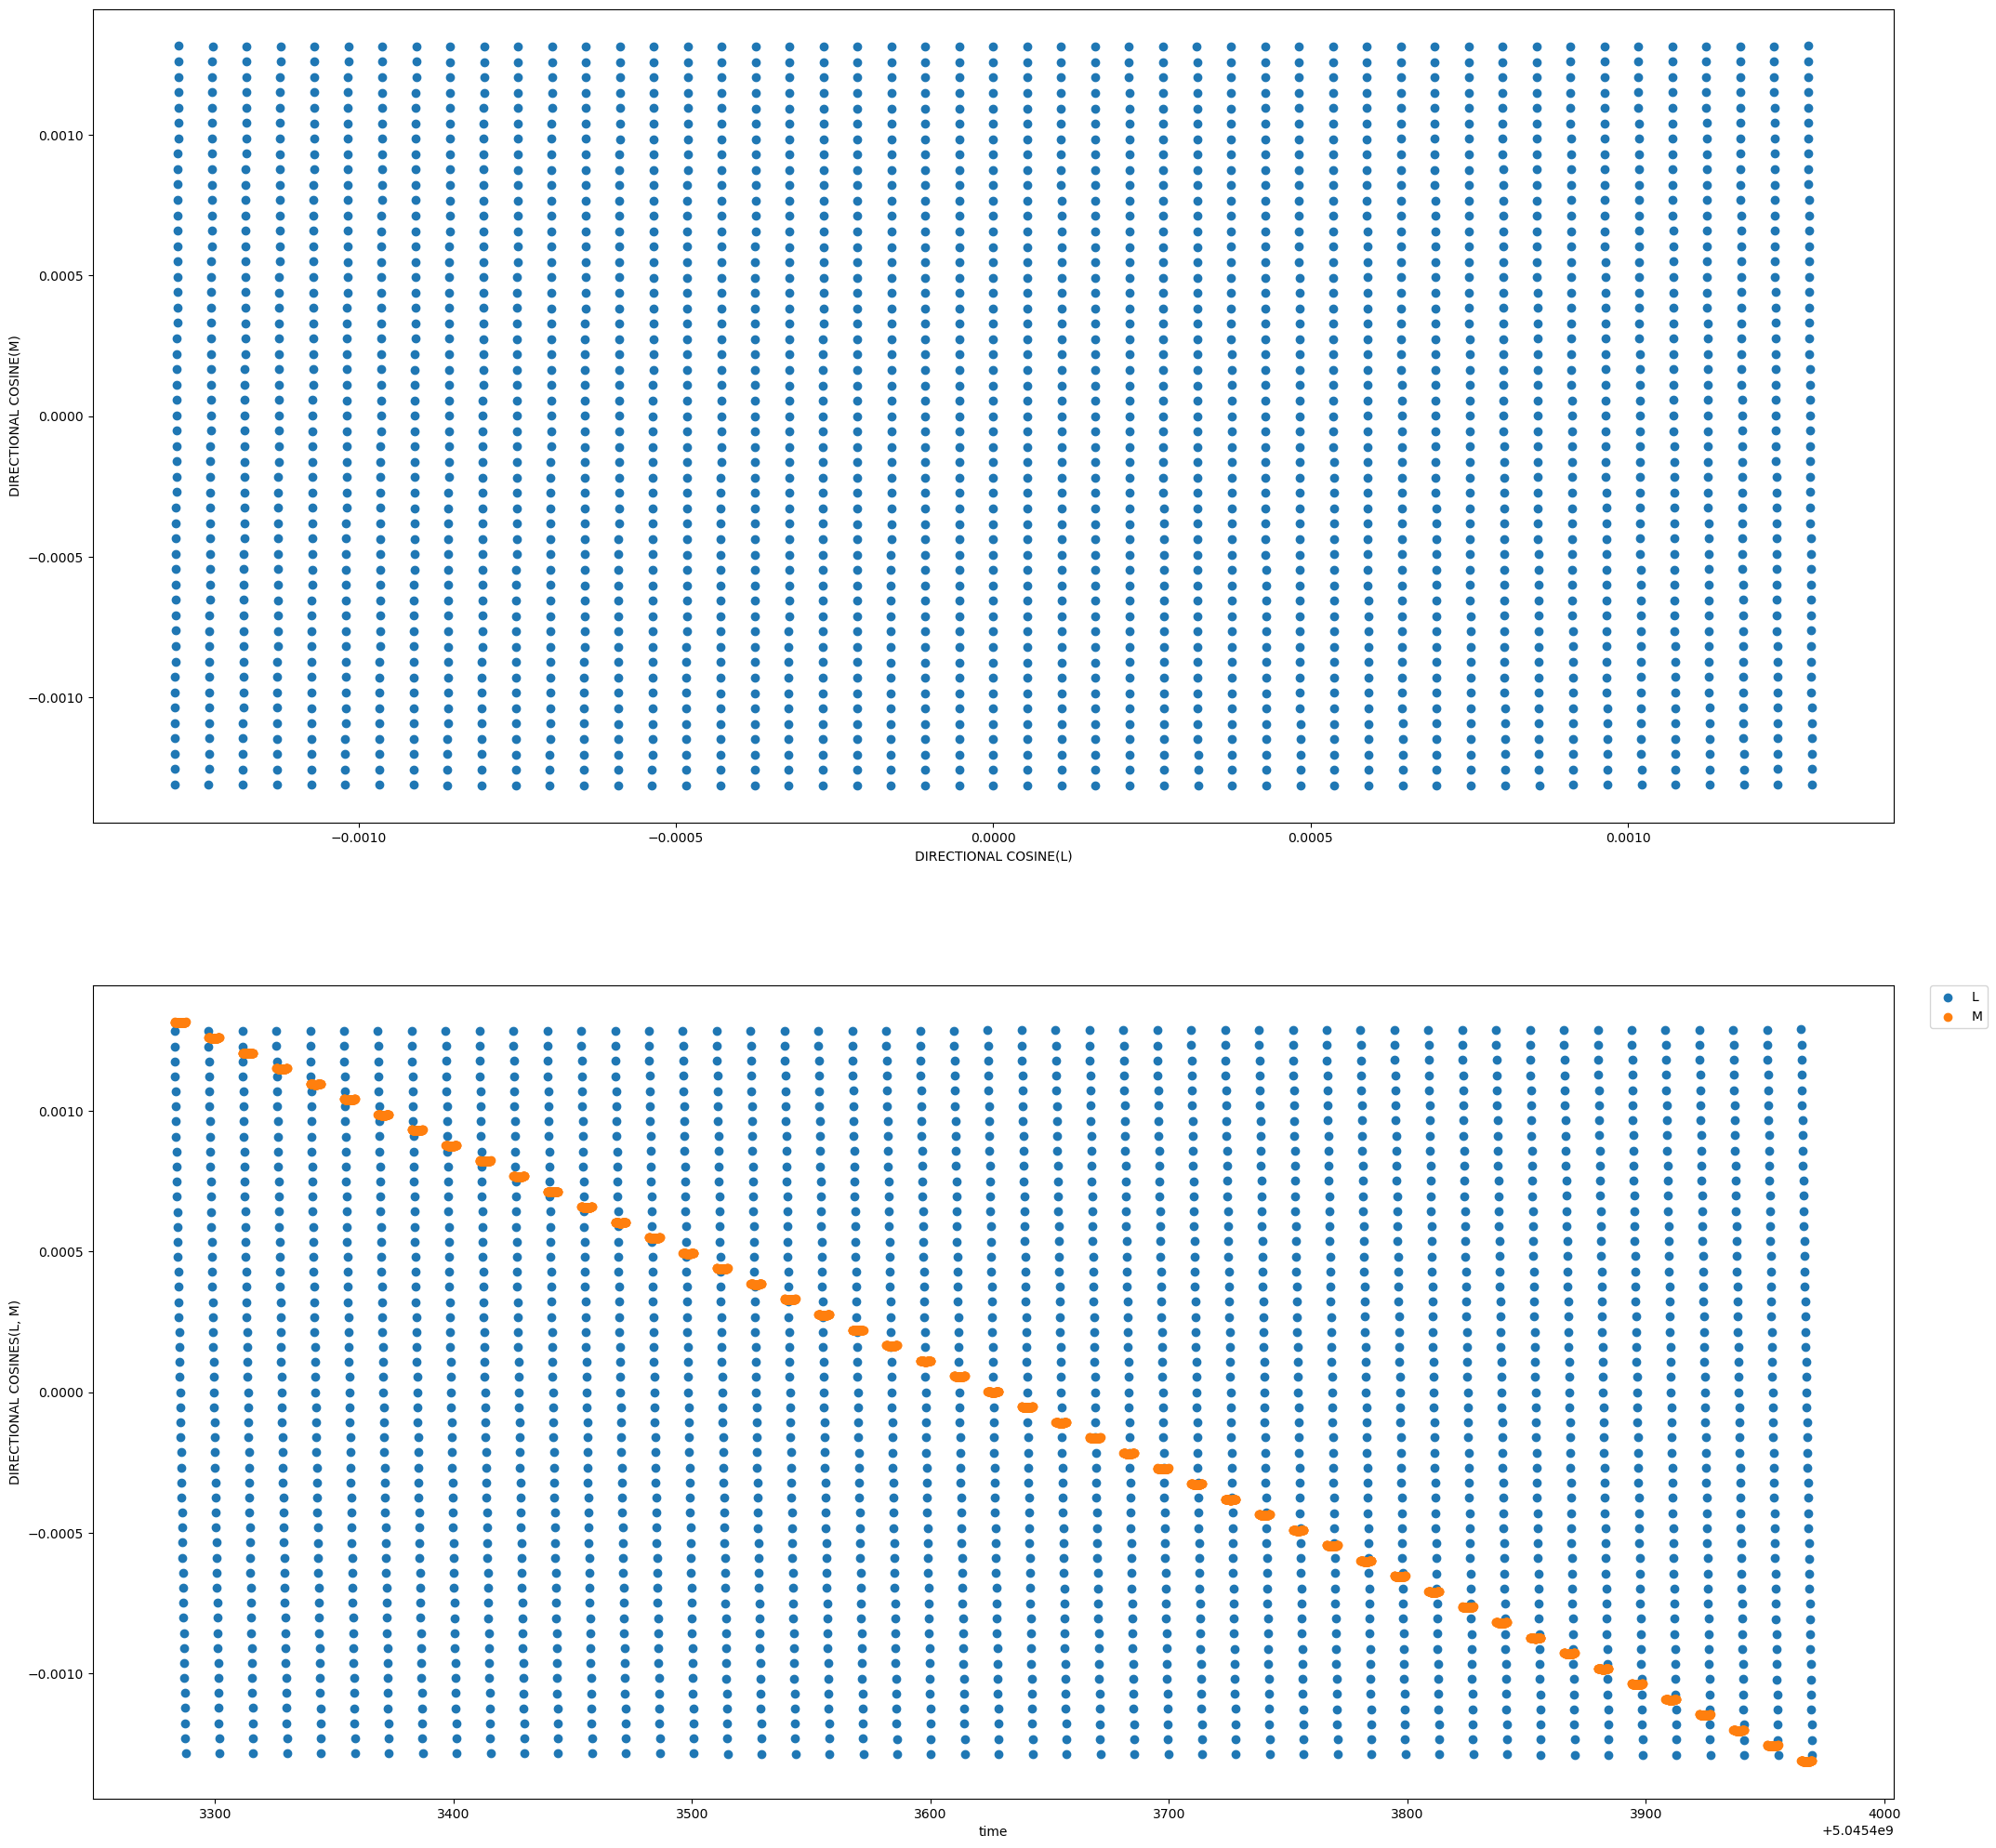

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].scatter(l, m)
ax[0].set_xlabel('DIRECTIONAL COSINE(L)')
ax[0].set_ylabel('DIRECTIONAL COSINE(M)')

ax[1].scatter(time, l, label='L')
ax[1].scatter(time, m, label='M')

ax[1].set_xlabel('time')
ax[1].set_ylabel('DIRECTIONAL COSINES(L, M)')

ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0.)

plt.show()

In [22]:
%%time
holog(
    holog_file='hack_file.holog.zarr', 
    padding_factor=50,
    apply_mask=True,
    parallel=True,
    phase_fit = True,
    block = True
)

[2023-03-27 17:15:54.174446 System Info]: Loading holography file hack_file.holog.zarr ...
[2023-03-27 17:15:54.176601 System Info]: Cell size: [5.31547362e-05 5.31547362e-05] Grid size [49 49]
[2023-03-27 17:15:54.176620 System Info]: Processing ant_id: ant_3
[2023-03-27 17:15:54.253739 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-03-27 17:15:55.211797 System Info]: [_holog_chunk] Applying phase correction ...
CPU times: user 4.52 s, sys: 468 ms, total: 4.99 s
Wall time: 4.48 s


[2023-03-27 17:16:00.791387 System Info]: Verifying hack_file.* files in path=./ ...
[2023-03-27 17:16:00.791842 System Info]: Found hack_file.holog.zarr directory ...
[2023-03-27 17:16:00.791995 System Info]: Found hack_file.image.zarr directory ...
[2023-03-27 17:16:00.792033 System Info]: Found hack_file.panel.zarr directory ...


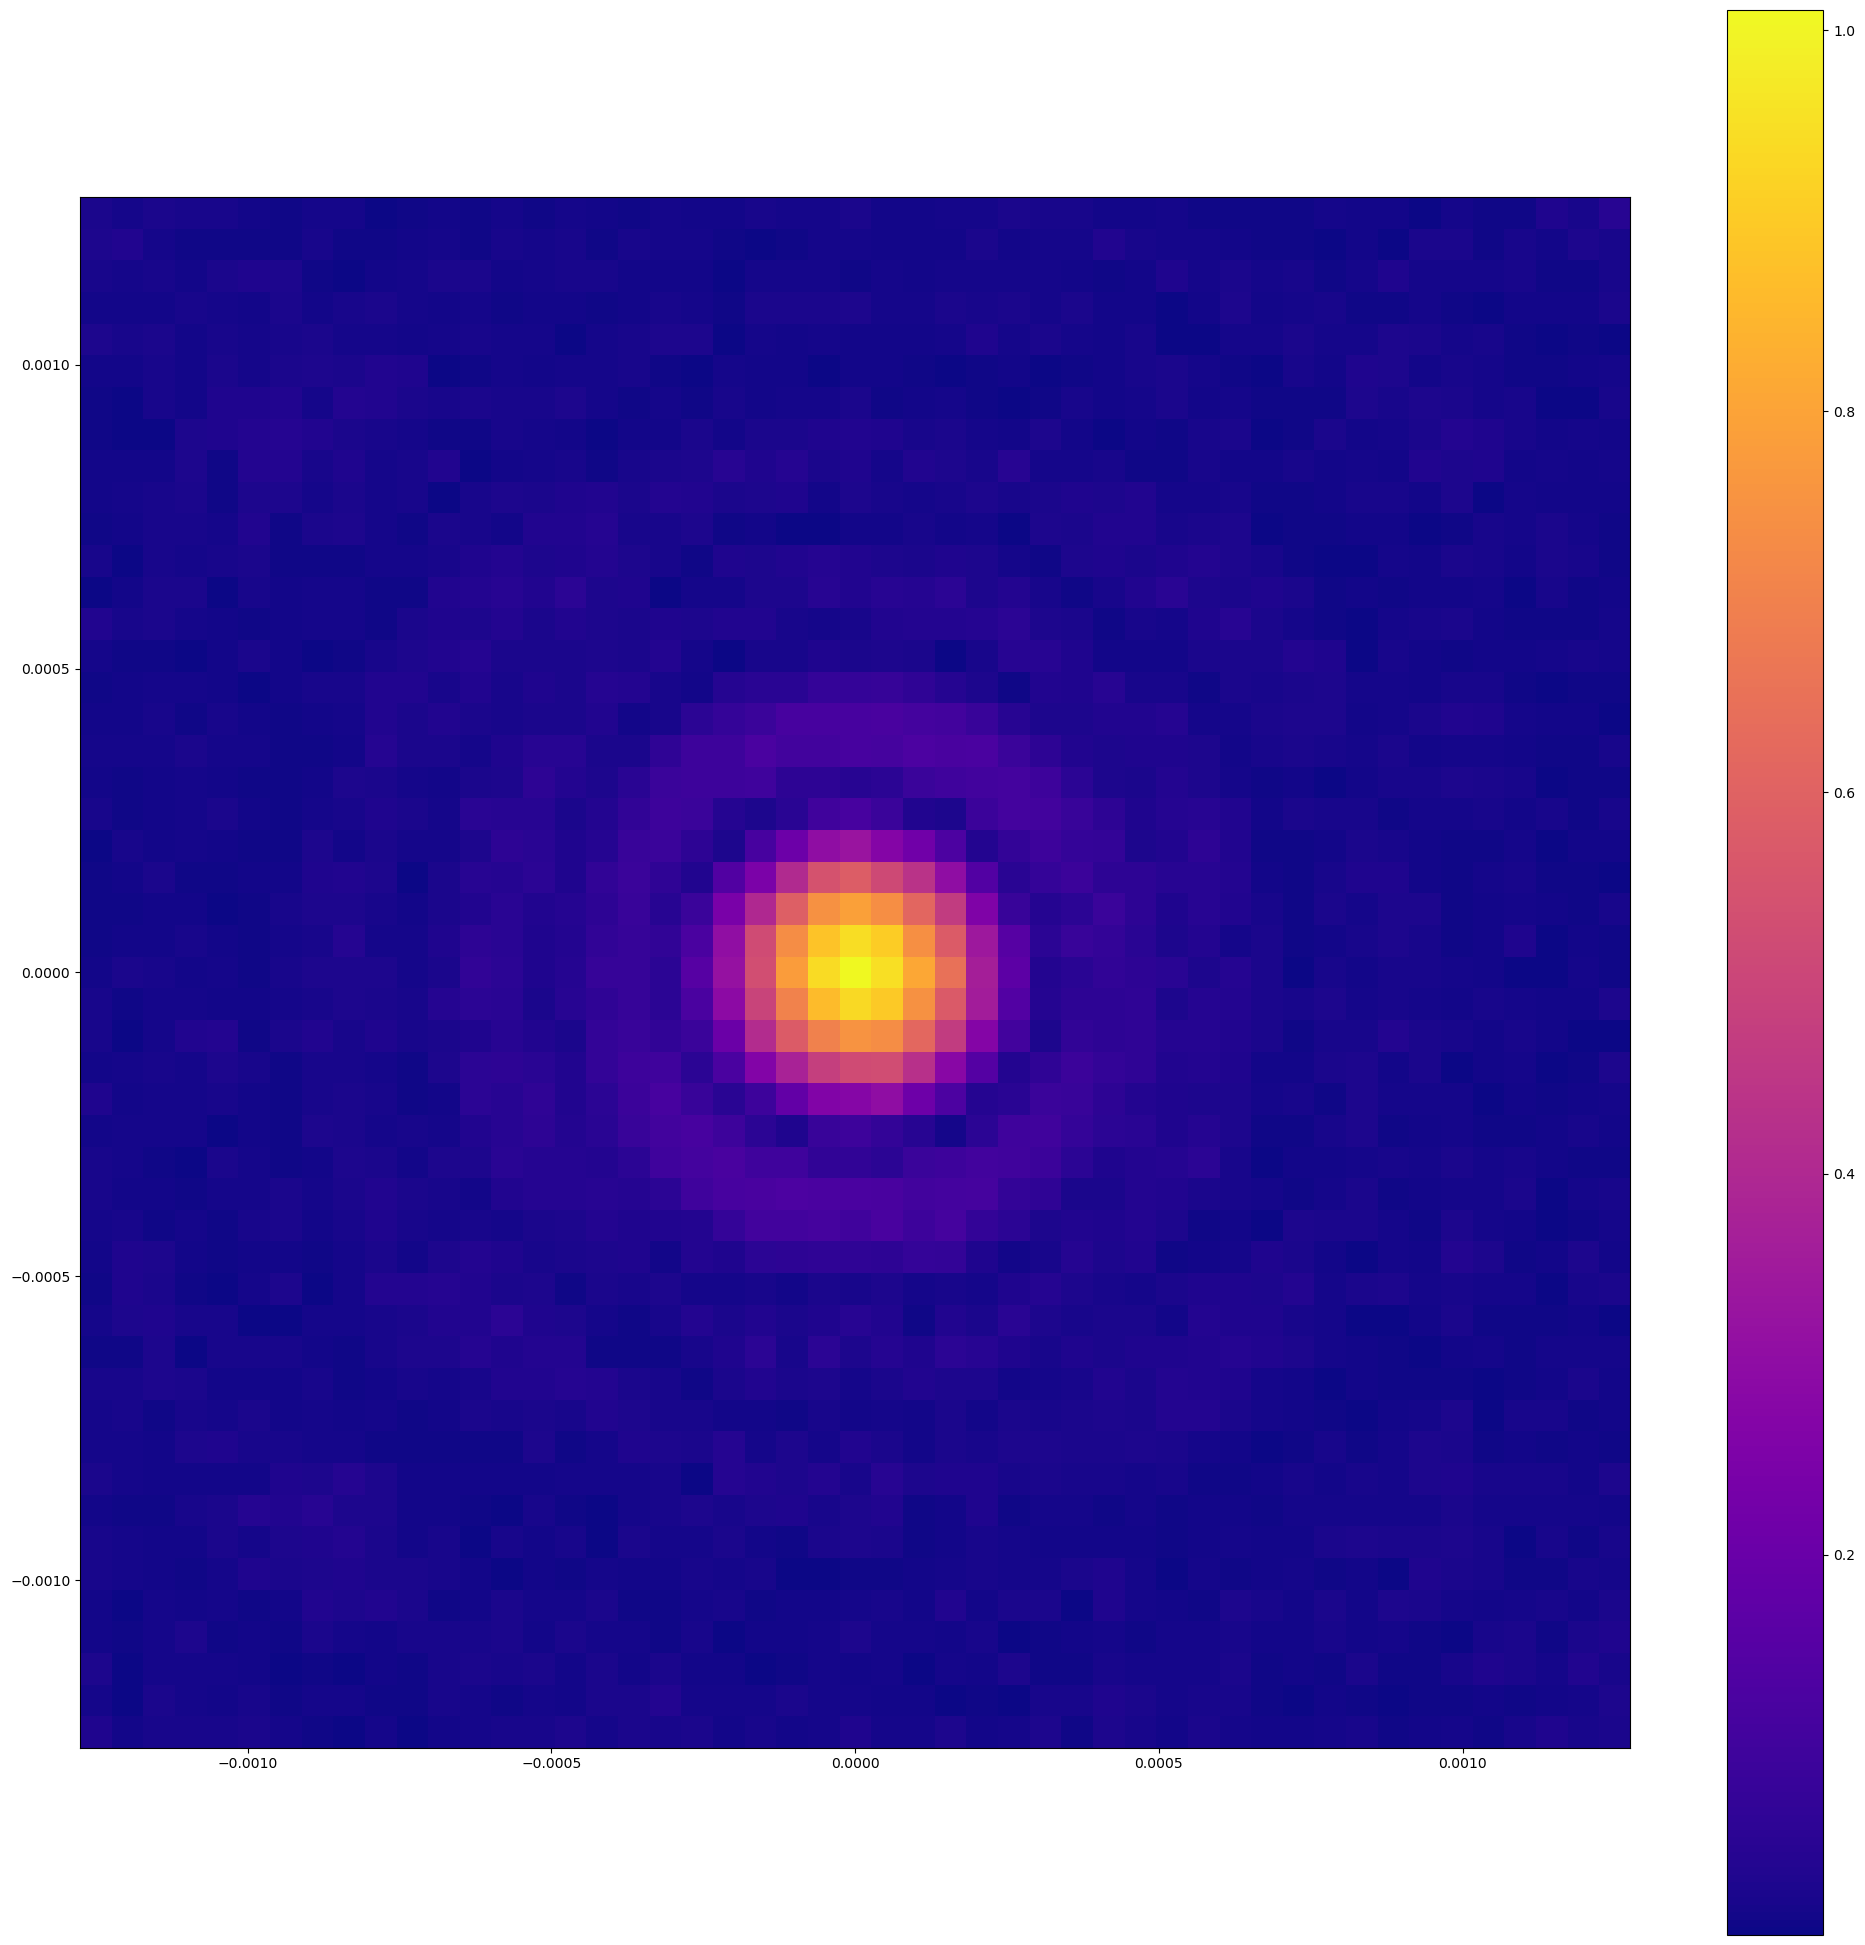

In [23]:
astrohack_data_file = AstrohackDataFile(file_stem='hack_file')

astrohack_data_file.image.open()
grid = astrohack_data_file.image[antenna][ddi].BEAM.values.mean(axis=0)[0, 0, ...]
l = astrohack_data_file.image[antenna][ddi].l.values
m = astrohack_data_file.image[antenna][ddi].m.values

fig, ax = plt.subplots()

beam = plt.imshow(np.abs(grid), extent=[l.min(), l.max(), m.min(), m.max()], cmap='plasma')
fig.colorbar(beam, ax=ax)

In [24]:
wavelength = scipy.constants.speed_of_light/astrohack_data_file.image[antenna][ddi].chan.values[0]

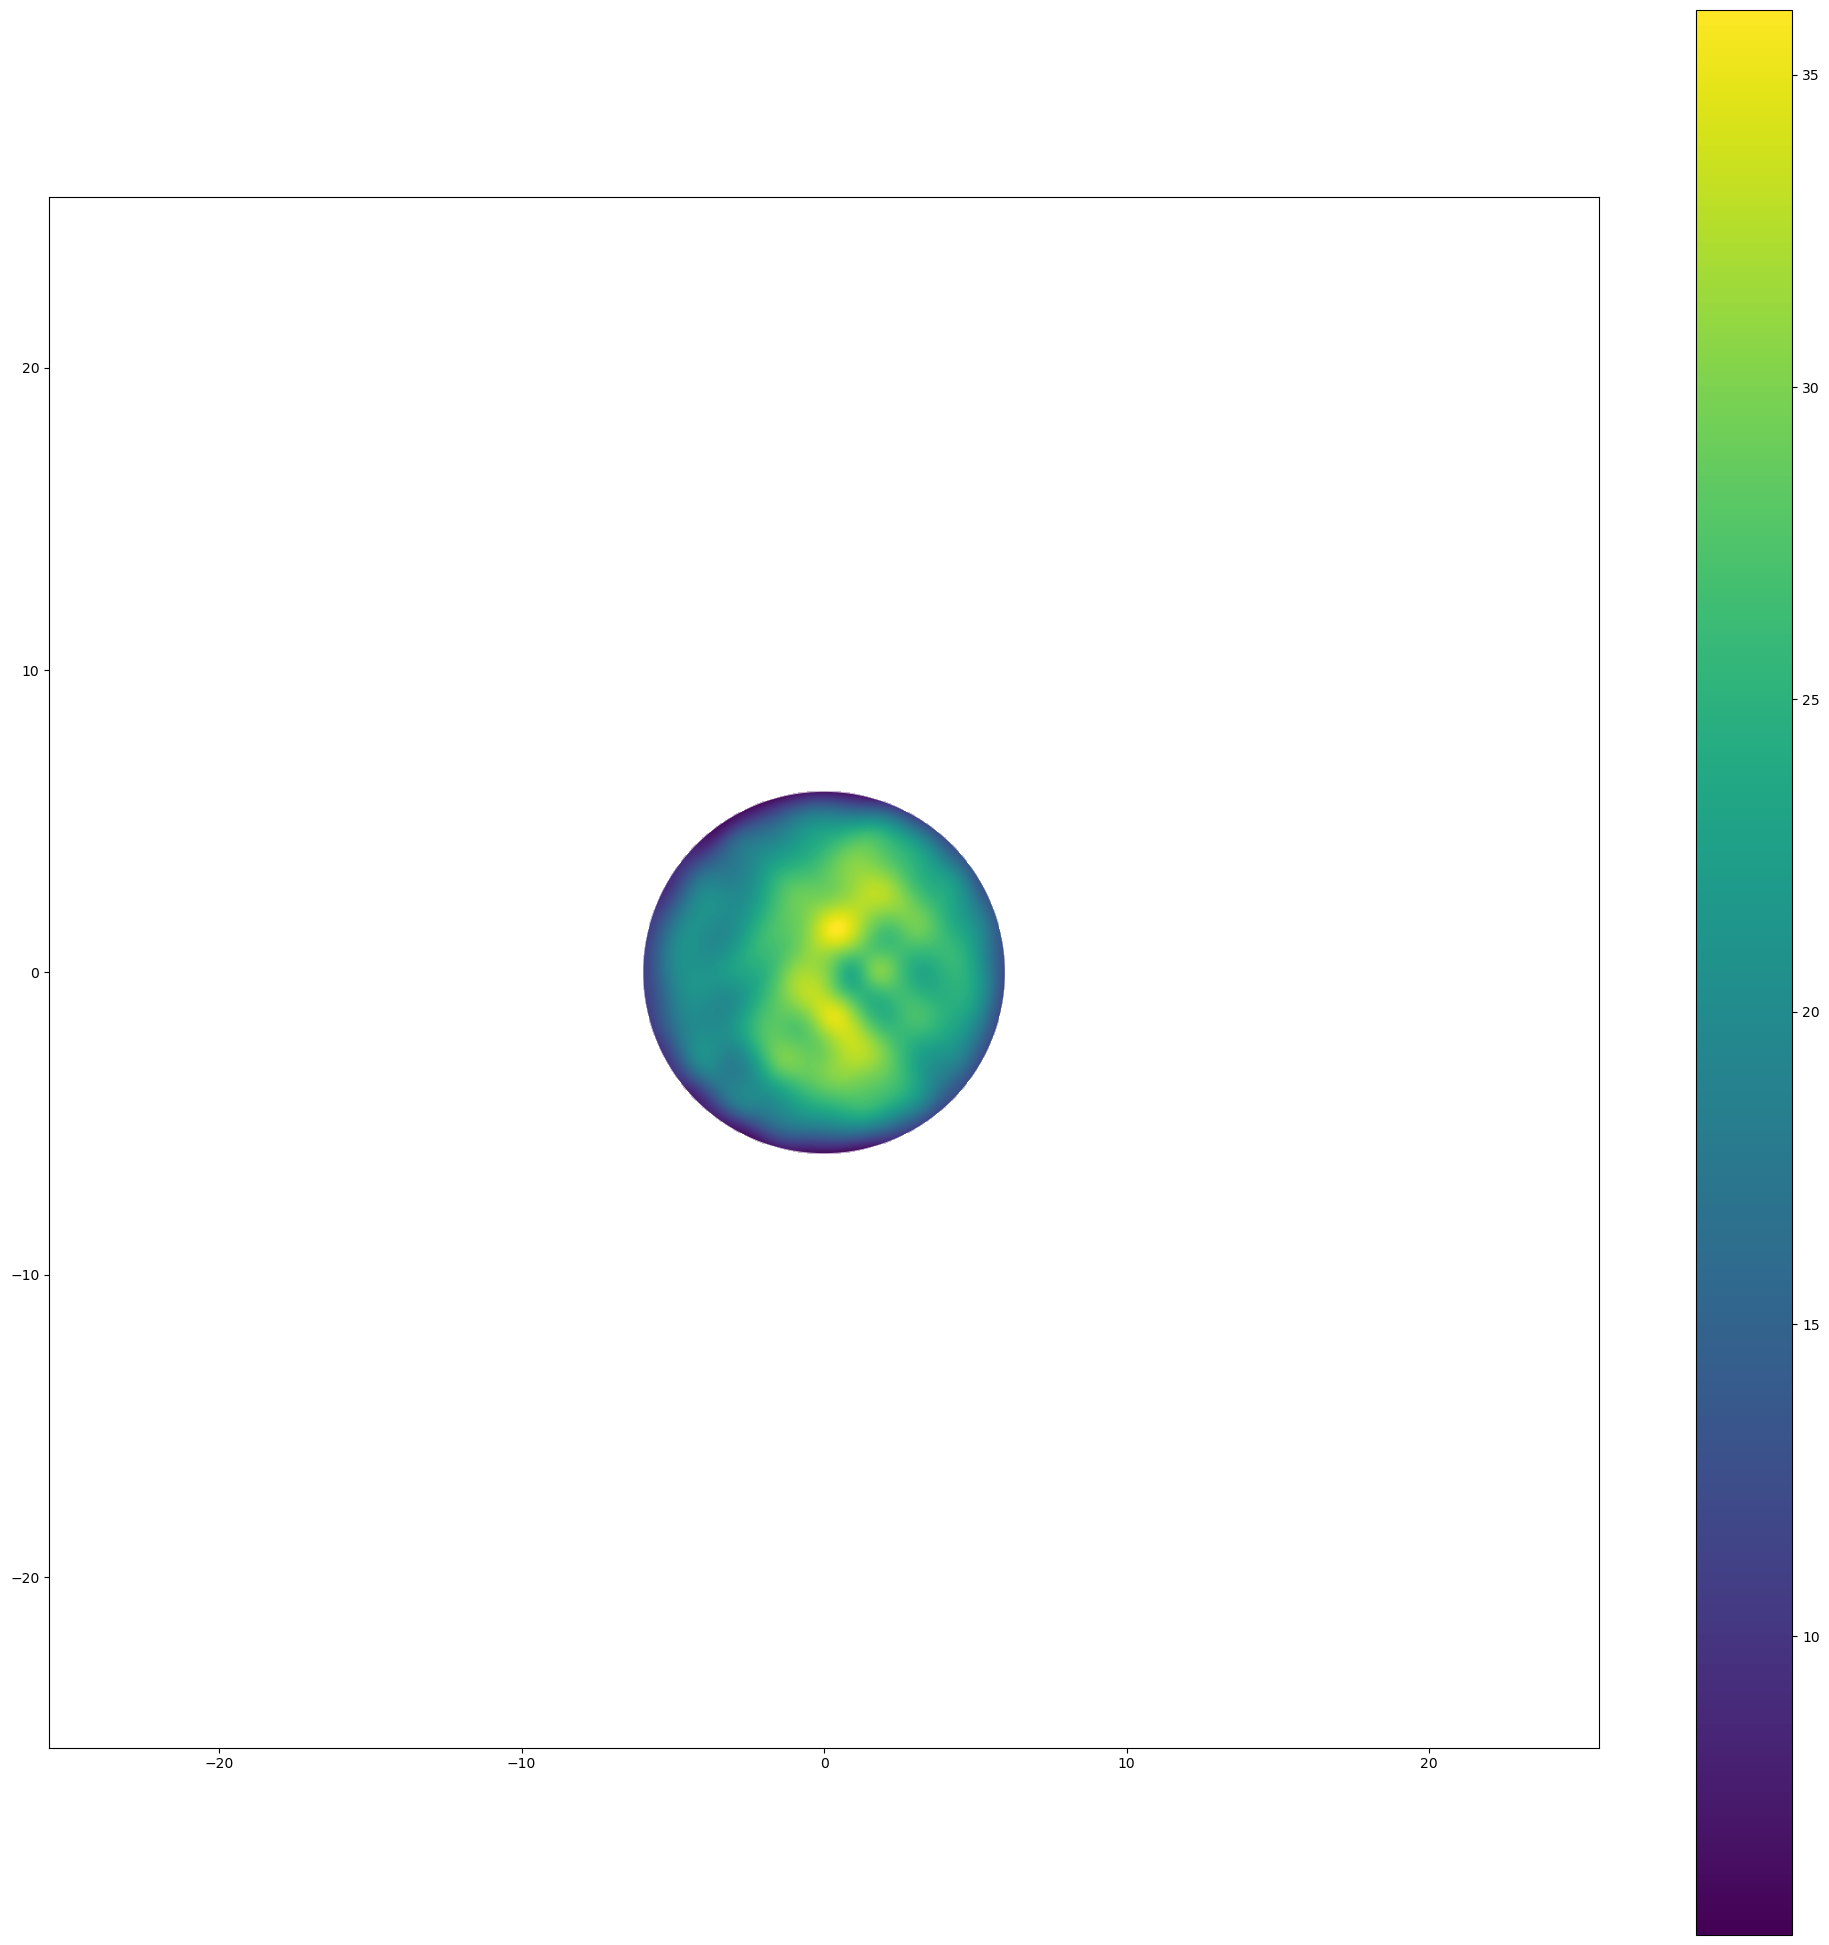

In [25]:
aperture = astrohack_data_file.image[antenna][ddi].APERTURE.values.mean(axis=0)[0, 0, ...]
u = astrohack_data_file.image[antenna][ddi].u.values*wavelength
v = astrohack_data_file.image[antenna][ddi].v.values*wavelength

fig, ax = plt.subplots()

image = plt.imshow(np.abs(aperture), extent=[u.min(), u.max(), v.min(), v.max()])
fig.colorbar(image, ax=ax)

circle = patches.Circle((0,0), 6, fill=False, color='white', alpha=0.7, linewidth=1.2)
ax.add_patch(circle)

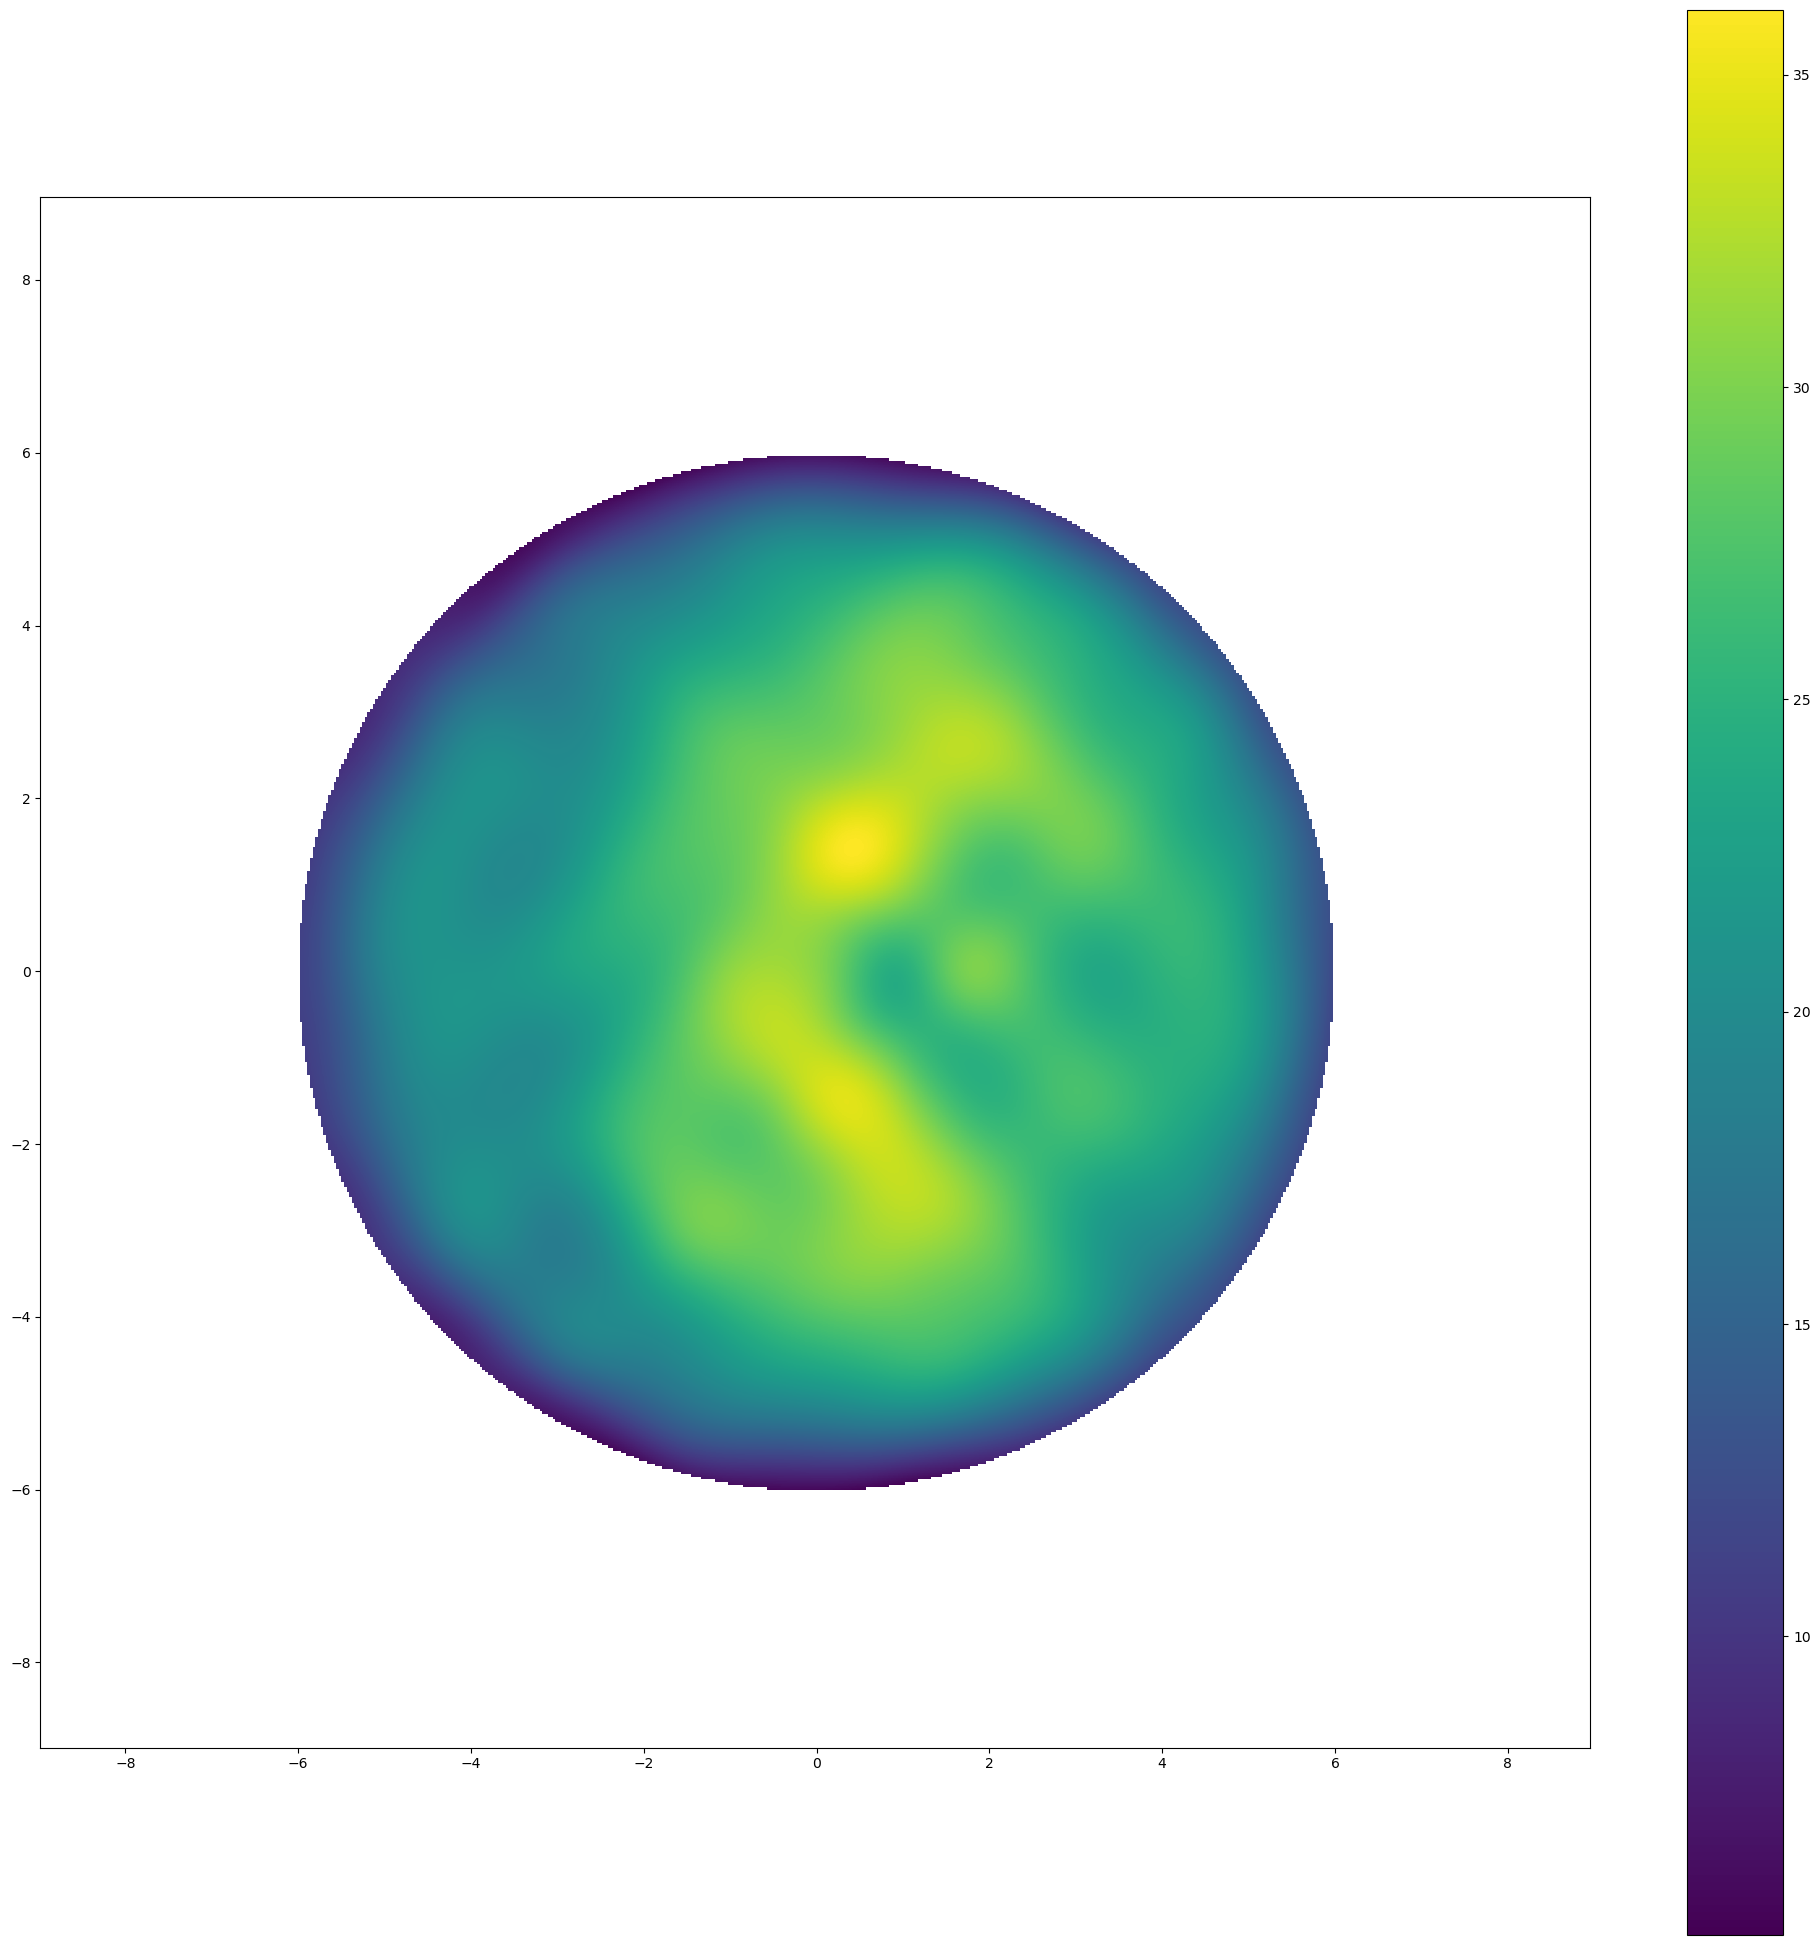

In [26]:
aperture = astrohack_data_file.image[antenna][ddi].AMPLITUDE.values.mean(axis=0)[0, 0, ...]
u = astrohack_data_file.image[antenna][ddi].u_prime.values*wavelength
v = astrohack_data_file.image[antenna][ddi].v_prime.values*wavelength

fig, ax = plt.subplots()

image = plt.imshow(aperture, extent=[u.min(), u.max(), v.min(), v.max()])
fig.colorbar(image, ax=ax)

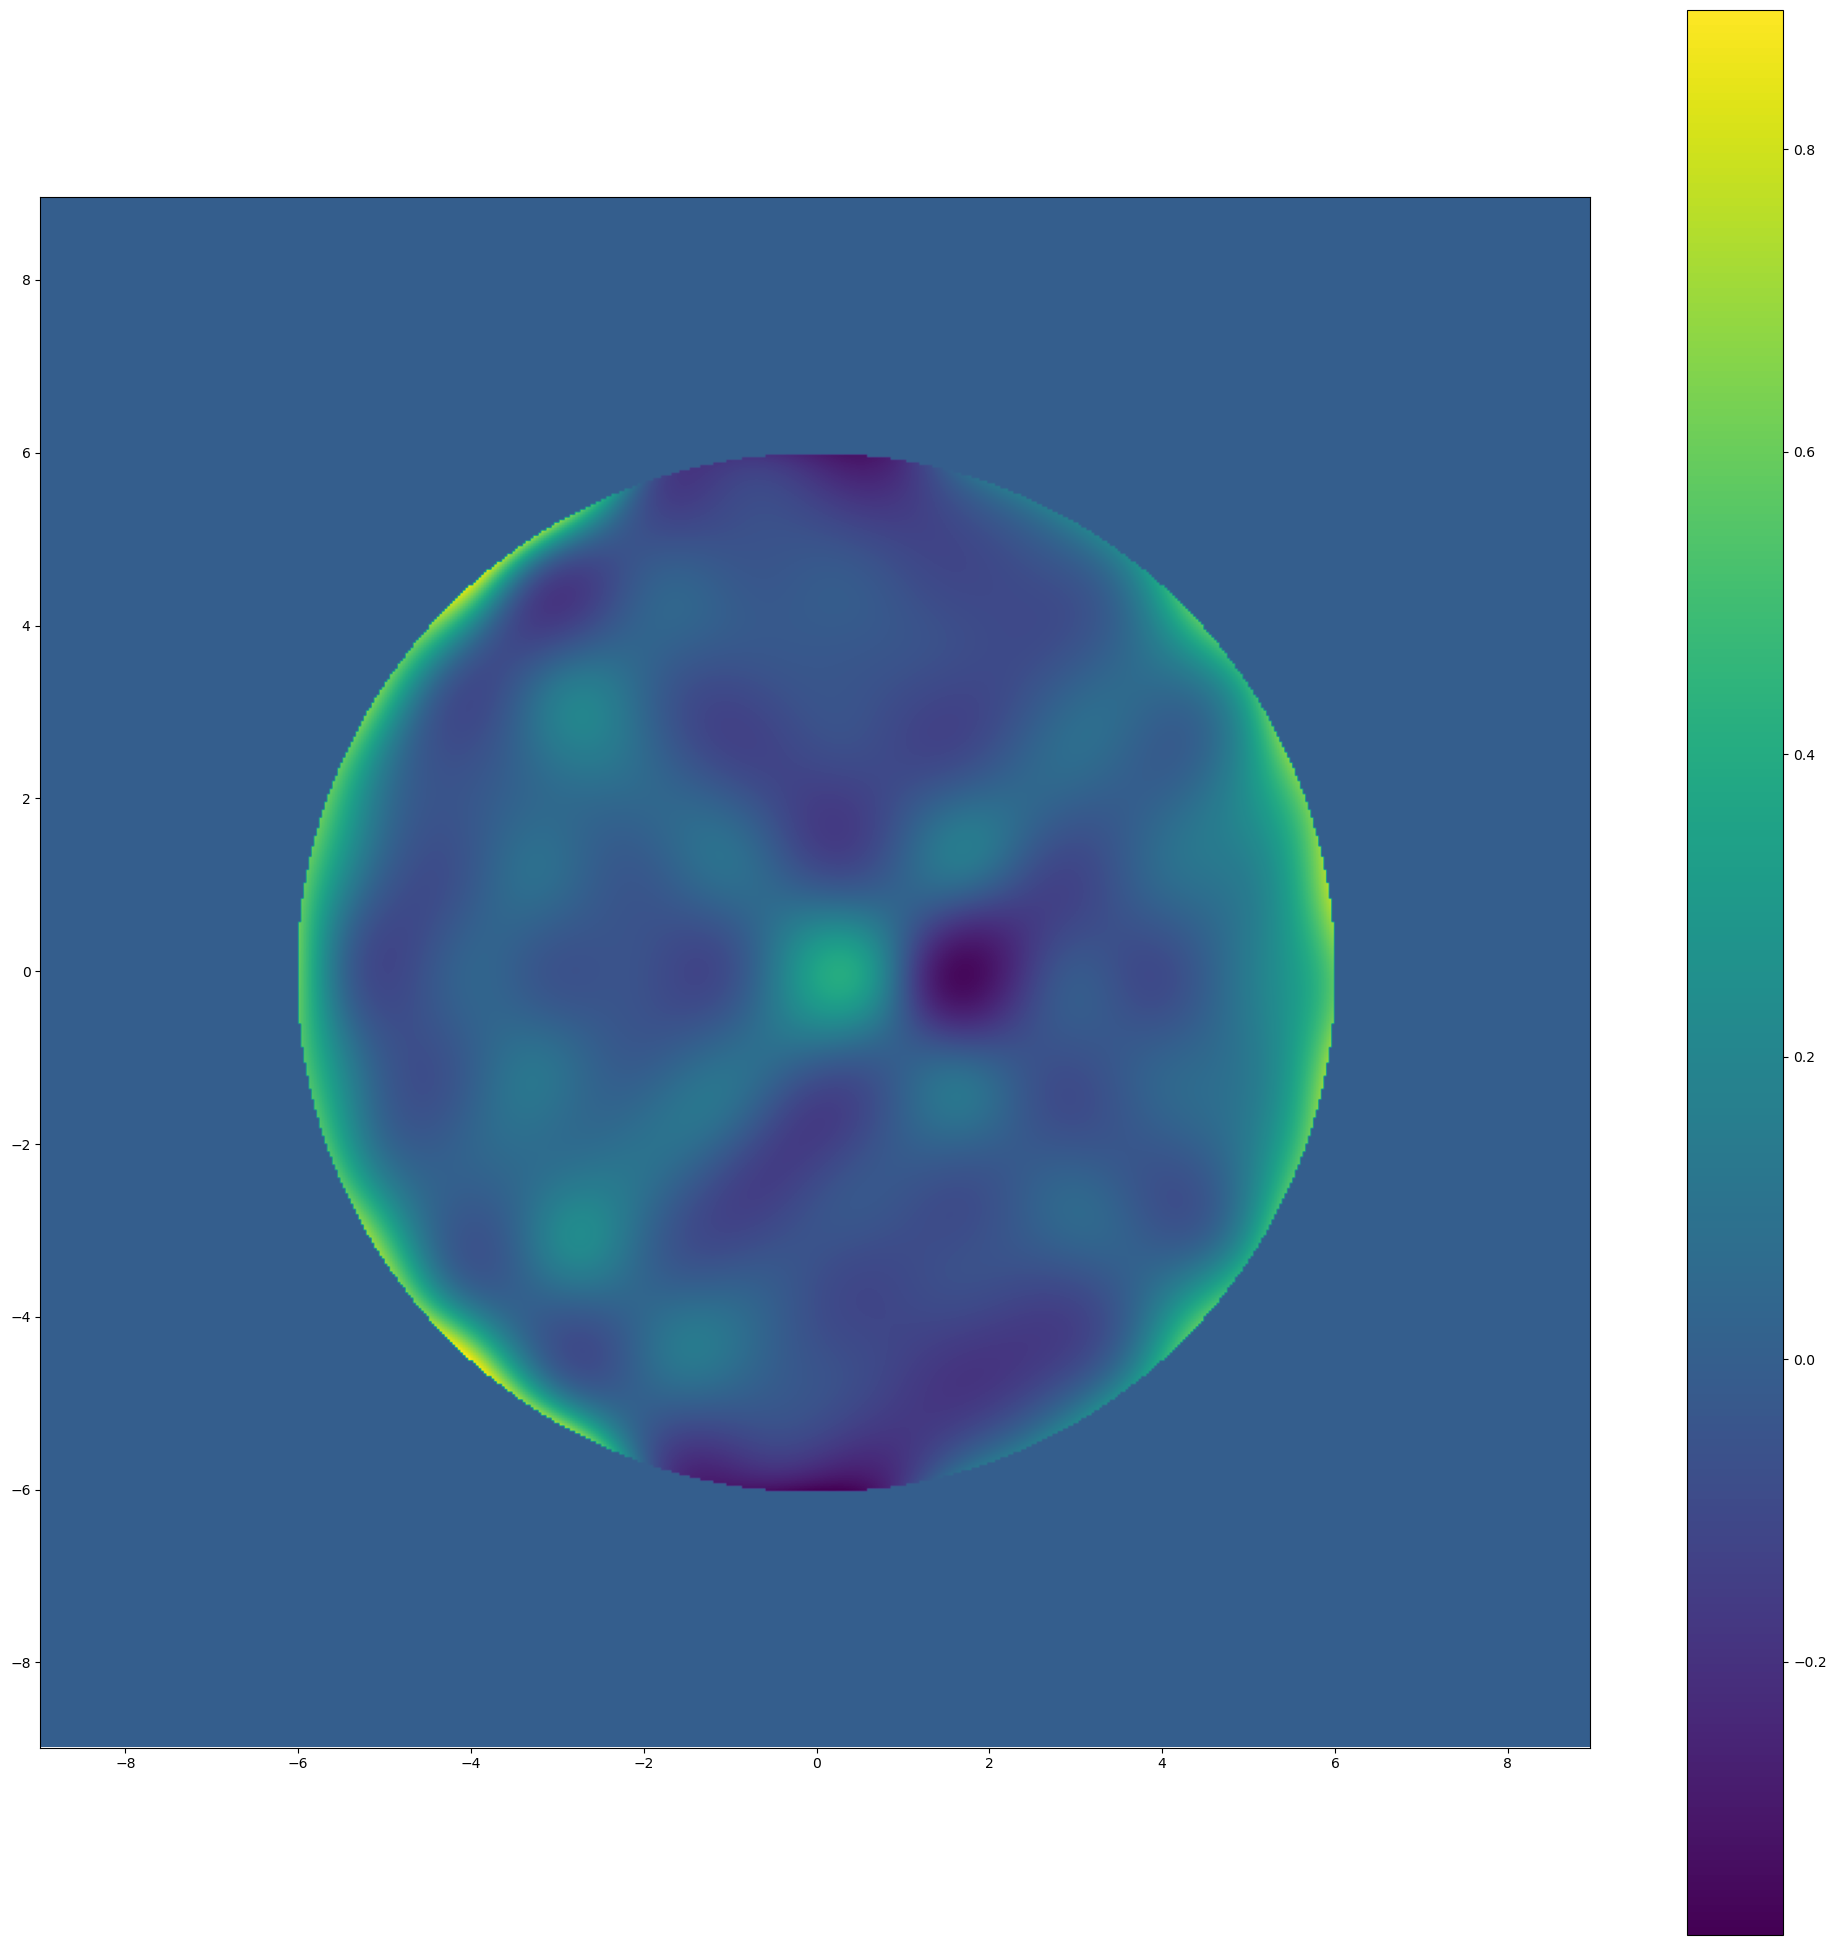

In [27]:
aperture = astrohack_data_file.image[antenna][ddi].ANGLE.values.mean(axis=0)[0, 0, ...]
u = astrohack_data_file.image[antenna][ddi].u_prime.values*wavelength
v = astrohack_data_file.image[antenna][ddi].v_prime.values*wavelength

fig, ax = plt.subplots()

image = plt.imshow(aperture, extent=[u.min(), u.max(), v.min(), v.max()])
fig.colorbar(image, ax=ax)

In [28]:
%%time
image = 'hack_file'

panel(
    holog_image=image, 
    outfile='hack_file',
    aipsdata=False, 
    unit='mm', 
)

[2023-03-27 17:16:41.543629 System Info]: Processing ddi_0 for ant_3
CPU times: user 1.42 s, sys: 499 ms, total: 1.92 s
Wall time: 1.33 s


In [29]:
data = AstrohackDataFile(file_stem='hack_file')

[2023-03-27 17:16:45.854063 System Info]: Verifying hack_file.* files in path=./ ...
[2023-03-27 17:16:45.854113 System Info]: Found hack_file.holog.zarr directory ...
[2023-03-27 17:16:45.854298 System Info]: Found hack_file.image.zarr directory ...
[2023-03-27 17:16:45.854462 System Info]: Found hack_file.panel.zarr directory ...


In [30]:
viewer = ApertureViewer(name="", data_file=data)

WidgetBox(sizing_mode='stretch_width')
    [0] Row(sizing_mode='stretch_width')
        [0] Card(height=925, sizing_mode='fixed', width=250)
            [0] Column(margin=5, sizing_mode='stretch_width', width=300)
                [0] StaticText(sizing_mode='stretch_width', value='<b></b>')
                [1] Select(name='Antenna', options=OrderedDict([('ant_3', ...]), sizing_mode='stretch_width', value='ant_3')
                [2] Select(name='DDI', options=OrderedDict([('ddi_0', ...]), sizing_mode='stretch_width', value='ddi_0')
                [3] Select(name='Type', options=OrderedDict([('Aperture', ...]), sizing_mode='stretch_width', value='Aperture')
        [1] Card(sizing_mode='stretch_width')
            [0] ParamMethod(method, _pane=ParamMethod, sizing_mode='stretch_width')
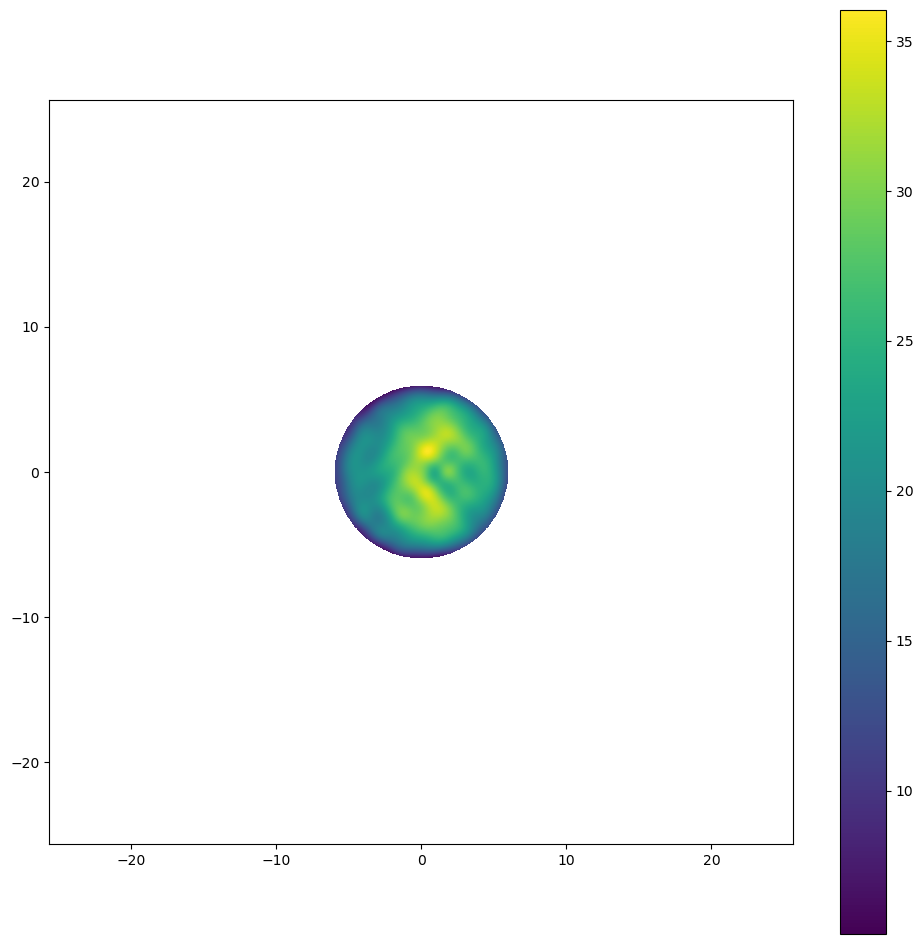

In [31]:
viewer.notebook()

In [21]:
# This will open a browser-based viewer
#viewer.app()